In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import itertools
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing 
#attractive and informative statistical graphics.
import seaborn as sns

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [4]:
df = pd.read_excel('https://github.com/Keerthanab14/Forecasting-system-to-predict-demand-of-products-at-a-retail-outlet/blob/main/superstoresales.xls?raw=true',parse_dates=['Order Date'])
#parse_date Converts a string representation of date to a DATE object. let's it know that we are dealing with dates

In [5]:
#Returns the first 5 rows of the dataframe. 
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [6]:
#Check for missing values
df.isna().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [7]:
#Check the different types of unique product categories included
df['Category'].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [8]:
#Now we create a dataframe which includes only data related to furniture sales. 
furniture = df.loc[df['Category'] == 'Furniture']
furniture

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9962,9963,CA-2015-168088,2015-03-19,2015-03-22,First Class,CM-12655,Corinna Mitchell,Home Office,United States,Houston,...,77041,Central,FUR-BO-10004218,Furniture,Bookcases,Bush Heritage Pine Collection 5-Shelf Bookcase...,383.4656,4,0.32,-67.6704
9964,9965,CA-2016-146374,2016-12-05,2016-12-10,Second Class,HE-14800,Harold Engle,Corporate,United States,Newark,...,19711,East,FUR-FU-10002671,Furniture,Furnishings,Electrix 20W Halogen Replacement Bulb for Zoom...,13.4000,1,0.00,6.4320
9980,9981,US-2015-151435,2015-09-06,2015-09-09,Second Class,SW-20455,Shaun Weien,Consumer,United States,Lafayette,...,70506,South,FUR-TA-10001039,Furniture,Tables,KI Adjustable-Height Table,85.9800,1,0.00,22.3548
9989,9990,CA-2014-110422,2014-01-21,2014-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028


In [9]:
#Know the earliest date recorded
furniture['Order Date'].min()

Timestamp('2014-01-06 00:00:00')

In [10]:
#Know the most recent date recorded
furniture['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

In [11]:
#Now we can remove unnecessary columns from the furniture dataframe. we only need date and sales done
cols = ['Row ID','Order ID','Ship Date','Ship Mode','Customer ID','Customer Name','Segment','Country','City','State','Postal Code','Region','Product ID','Category','Sub-Category','Product Name','Quantity','Discount','Profit']
furniture.drop(cols,axis=1,inplace=True)
furniture

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
3,2015-10-11,957.5775
5,2014-06-09,48.8600
10,2014-06-09,1706.1840
...,...,...
9962,2015-03-19,383.4656
9964,2016-12-05,13.4000
9980,2015-09-06,85.9800
9989,2014-01-21,25.2480


In [12]:
#Now let's sort furniture datframe according to order date
furniture = furniture.sort_values('Order Date')
furniture

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940
...,...,...
7636,2017-12-29,258.750
7632,2017-12-29,1207.840
5131,2017-12-29,101.120
7635,2017-12-29,300.980


In [13]:
#Now let's find how much total furniture sales occurred on each date
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture

,Order Date,Sales
0,2014-01-06,2573.8200
1,2014-01-07,76.7280
2,2014-01-10,51.9400
3,2014-01-11,9.9400
4,2014-01-13,879.9390
...,...,...
884,2017-12-24,1393.4940
885,2017-12-25,832.4540
886,2017-12-28,551.2568
887,2017-12-29,2330.7180


In [14]:
#Now let's set the Order date column as the index column
furniture = furniture.set_index('Order Date')
furniture

,Sales
Order Date,
2014-01-06,2573.8200
2014-01-07,76.7280
2014-01-10,51.9400
2014-01-11,9.9400
2014-01-13,879.9390
...,...
2017-12-24,1393.4940
2017-12-25,832.4540
2017-12-28,551.2568


In [15]:
#Now let's see whether there is any frequency in the dataframe
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [16]:
#Now let's resample the data into means of monthly sales of furniture and save this into a new variable called Order date
#MS = month start frequency, SMS=semi month start, Q=quarterly, W=weekly,Y=yearly,M=monthly
y_furniture = furniture['Sales'].resample('MS').mean()
y_furniture

Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049188
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
2016-01-01     508.182867
2016-02-01     356.868273
2016-03-01     609.575810
2016-04-01     695.373158
2016-05-01     687.265227
2016-06-01     816.910750
2016-07-01     768.736412
2016-08-01     734.307782
2016-09-01    1135.953371
2016-10-01     624.872474
2016-11-01    1271.345152
2016-12-01    1410.719808
2017-01-01     397.602133
2017-02-01     528.179800
2

In [17]:
#dataframe with only office category values
office= df.loc[df['Category'] == 'Office Supplies']
office

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2,0.2,2.5164
6,7,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.280,4,0.0,1.9656
8,9,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.504,3,0.2,5.7825
9,10,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,114.900,5,0.0,34.4700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982,9983,US-2016-157728,2016-09-22,2016-09-28,Standard Class,RC-19960,Ryan Crowe,Consumer,United States,Grand Rapids,...,49505,Central,OFF-PA-10002195,Office Supplies,Paper,"RSVP Cards & Envelopes, Blank White, 8-1/2"" X ...",35.560,7,0.0,16.7132
9984,9985,CA-2015-100251,2015-05-17,2015-05-23,Standard Class,DV-13465,Dianna Vittorini,Consumer,United States,Long Beach,...,11561,East,OFF-LA-10003766,Office Supplies,Labels,Self-Adhesive Removable Labels,31.500,10,0.0,15.1200
9985,9986,CA-2015-100251,2015-05-17,2015-05-23,Standard Class,DV-13465,Dianna Vittorini,Consumer,United States,Long Beach,...,11561,East,OFF-SU-10000898,Office Supplies,Supplies,Acme Hot Forged Carbon Steel Scissors with Nic...,55.600,4,0.0,16.1240
9992,9993,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.600,4,0.0,13.3200


In [18]:
office['Order Date'].min()

Timestamp('2014-01-03 00:00:00')

In [19]:
office['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

In [20]:
office.drop(cols,axis=1,inplace=True)
office

,Order Date,Sales
2,2016-06-12,14.620
4,2015-10-11,22.368
6,2014-06-09,7.280
8,2014-06-09,18.504
9,2014-06-09,114.900
...,...,...
9982,2016-09-22,35.560
9984,2015-05-17,31.500
9985,2015-05-17,55.600
9992,2017-02-26,29.600


In [21]:
office= office.sort_values('Order Date')
office

,Order Date,Sales
7980,2014-01-03,16.448
740,2014-01-04,272.736
739,2014-01-04,11.784
741,2014-01-04,3.540
1759,2014-01-05,19.536
...,...,...
5091,2017-12-30,3.024
1297,2017-12-30,20.720
908,2017-12-30,52.776
1296,2017-12-30,13.904


In [22]:
office = office.groupby('Order Date')['Sales'].sum().reset_index()
office

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,685.340
4,2014-01-07,10.430
...,...,...
1143,2017-12-26,814.594
1144,2017-12-27,13.248
1145,2017-12-28,1091.244
1146,2017-12-29,282.440


In [23]:
office = office.set_index('Order Date')
office

,Sales
Order Date,
2014-01-03,16.448
2014-01-04,288.060
2014-01-05,19.536
2014-01-06,685.340
2014-01-07,10.430
...,...
2017-12-26,814.594
2017-12-27,13.248
2017-12-28,1091.244


In [24]:
office.index

DatetimeIndex(['2014-01-03', '2014-01-04', '2014-01-05', '2014-01-06',
               '2014-01-07', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-16', '2014-01-18',
               ...
               '2017-12-21', '2017-12-22', '2017-12-23', '2017-12-24',
               '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=1148, freq=None)

In [25]:
y_office = office['Sales'].resample('MS').mean()
y_office

Order Date
2014-01-01     285.357647
2014-02-01      63.042588
2014-03-01     391.176318
2014-04-01     464.794750
2014-05-01     324.346545
2014-06-01     588.774409
2014-07-01     756.060400
2014-08-01     541.879143
2014-09-01    1015.677704
2014-10-01     267.078815
2014-11-01     959.372714
2014-12-01     692.556231
2015-01-01     129.198571
2015-02-01     335.504188
2015-03-01     690.545522
2015-04-01     502.342320
2015-05-01     364.549440
2015-06-01     560.407737
2015-07-01     205.214739
2015-08-01     558.814667
2015-09-01     772.230680
2015-10-01     361.392083
2015-11-01     757.790357
2015-12-01     540.055800
2016-01-01     331.230125
2016-02-01     357.597368
2016-03-01     693.877240
2016-04-01     462.932478
2016-05-01     449.489724
2016-06-01     436.072400
2016-07-01     587.474727
2016-08-01     344.605385
2016-09-01     830.847786
2016-10-01     678.408083
2016-11-01     787.972231
2016-12-01    1357.055929
2017-01-01     967.013136
2017-02-01     389.882737
2

In [26]:
#dataframe with only technology category
technology = df.loc[df['Category'] == 'Technology']
technology

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
7,8,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.152,6,0.2,90.7152
11,12,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002033,Technology,Phones,Konftel 250 Conference phone - Charcoal black,911.424,4,0.2,68.3568
19,20,CA-2014-143336,2014-08-27,2014-09-01,Second Class,ZD-21925,Zuschuss Donatelli,Consumer,United States,San Francisco,...,94109,West,TEC-PH-10001949,Technology,Phones,Cisco SPA 501G IP Phone,213.480,3,0.2,16.0110
26,27,CA-2016-121755,2016-01-16,2016-01-20,Second Class,EH-13945,Eric Hoffmann,Consumer,United States,Los Angeles,...,90049,West,TEC-AC-10003027,Technology,Accessories,Imation 8GB Mini TravelDrive USB 2.0 Flash Drive,90.570,3,0.0,11.7741
35,36,CA-2016-117590,2016-12-08,2016-12-10,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080,Central,TEC-PH-10004977,Technology,Phones,GE 30524EE4,1097.544,7,0.2,123.4737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9983,9984,US-2016-157728,2016-09-22,2016-09-28,Standard Class,RC-19960,Ryan Crowe,Consumer,United States,Grand Rapids,...,49505,Central,TEC-PH-10001305,Technology,Phones,Panasonic KX TS208W Corded phone,97.980,2,0.0,27.4344
9986,9987,CA-2016-125794,2016-09-29,2016-10-03,Standard Class,ML-17410,Maris LaWare,Consumer,United States,Los Angeles,...,90008,West,TEC-AC-10003399,Technology,Accessories,Memorex Mini Travel Drive 64 GB USB 2.0 Flash ...,36.240,1,0.0,15.2208
9987,9988,CA-2017-163629,2017-11-17,2017-11-21,Standard Class,RA-19885,Ruben Ausman,Corporate,United States,Athens,...,30605,South,TEC-AC-10001539,Technology,Accessories,Logitech G430 Surround Sound Gaming Headset wi...,79.990,1,0.0,28.7964
9988,9989,CA-2017-163629,2017-11-17,2017-11-21,Standard Class,RA-19885,Ruben Ausman,Corporate,United States,Athens,...,30605,South,TEC-PH-10004006,Technology,Phones,Panasonic KX - TS880B Telephone,206.100,5,0.0,55.6470


In [27]:
technology['Order Date'].min()

Timestamp('2014-01-06 00:00:00')

In [28]:
technology['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

In [29]:
technology.drop(cols,axis=1,inplace=True)
technology

,Order Date,Sales
7,2014-06-09,907.152
11,2014-06-09,911.424
19,2014-08-27,213.480
26,2016-01-16,90.570
35,2016-12-08,1097.544
...,...,...
9983,2016-09-22,97.980
9986,2016-09-29,36.240
9987,2017-11-17,79.990
9988,2017-11-17,206.100


In [30]:
technology = technology.sort_values('Order Date')
technology

,Order Date,Sales
7478,2014-01-06,755.960
7477,2014-01-06,391.980
593,2014-01-09,31.200
765,2014-01-13,646.740
1913,2014-01-15,149.950
...,...,...
4924,2017-12-25,90.480
2569,2017-12-27,164.388
573,2017-12-28,14.850
1878,2017-12-29,302.376


In [31]:
technology = technology.groupby('Order Date')['Sales'].sum().reset_index()
technology

,Order Date,Sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


In [32]:
technology = technology.set_index('Order Date')
technology

,Sales
Order Date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


In [33]:
technology.index

DatetimeIndex(['2014-01-06', '2014-01-09', '2014-01-13', '2014-01-15',
               '2014-01-16', '2014-01-20', '2014-01-26', '2014-02-01',
               '2014-02-02', '2014-02-06',
               ...
               '2017-12-18', '2017-12-21', '2017-12-22', '2017-12-23',
               '2017-12-24', '2017-12-25', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=824, freq=None)

In [34]:
y_technology = technology['Sales'].resample('MS').mean()
y_technology

Order Date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
2017-01-01    1195.218071
2017-02-01     430.501714
2

# Plotting the sales data for each categories

<AxesSubplot:xlabel='Order Date'>

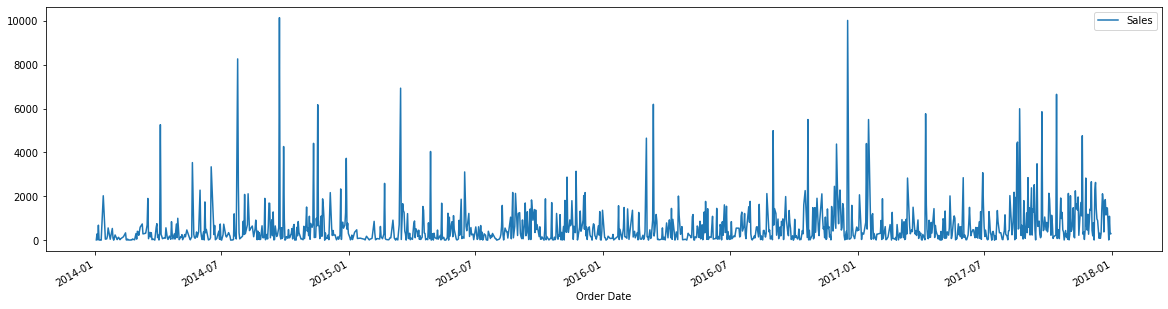

In [35]:
office.plot(figsize=(20,5))

<AxesSubplot:xlabel='Order Date'>

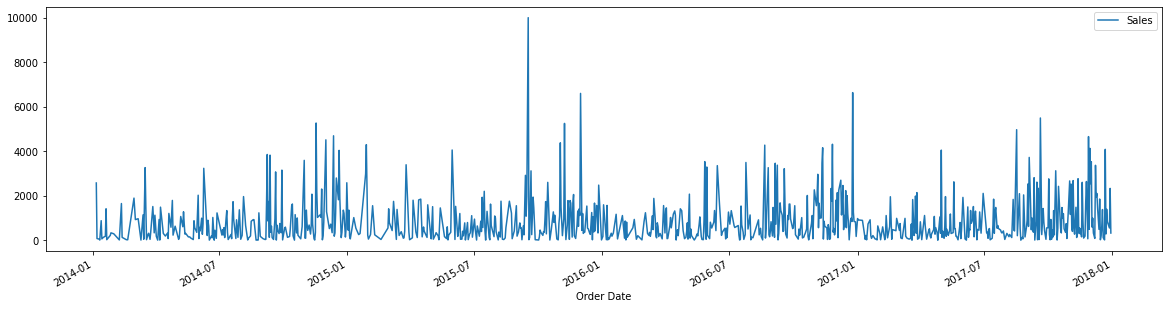

In [36]:
furniture.plot(figsize=(20,5))

<AxesSubplot:xlabel='Order Date'>

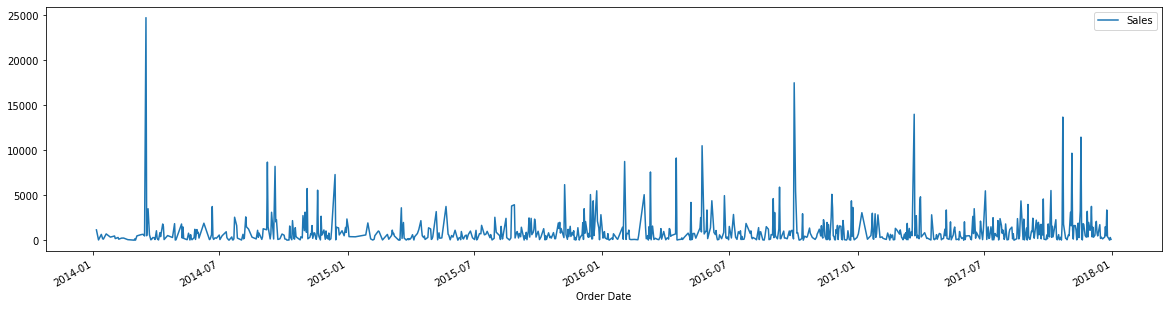

In [37]:
technology.plot(figsize=(20,5))

<AxesSubplot:xlabel='Order Date'>

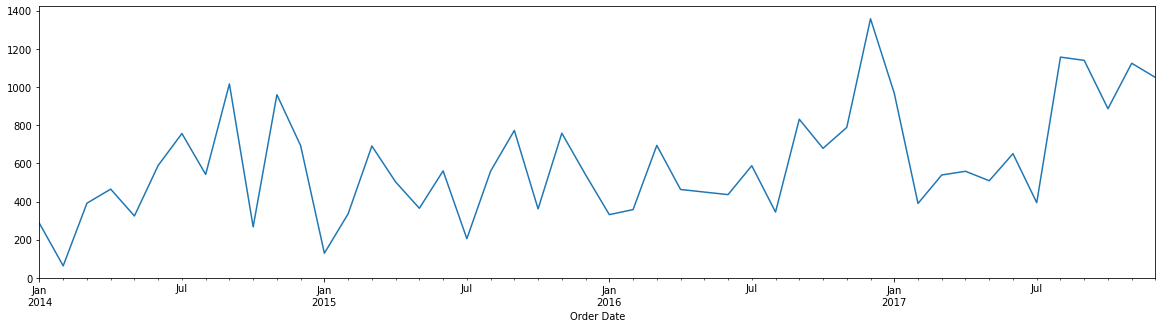

In [38]:
y_office.plot(figsize=(20,5))

<AxesSubplot:xlabel='Order Date'>

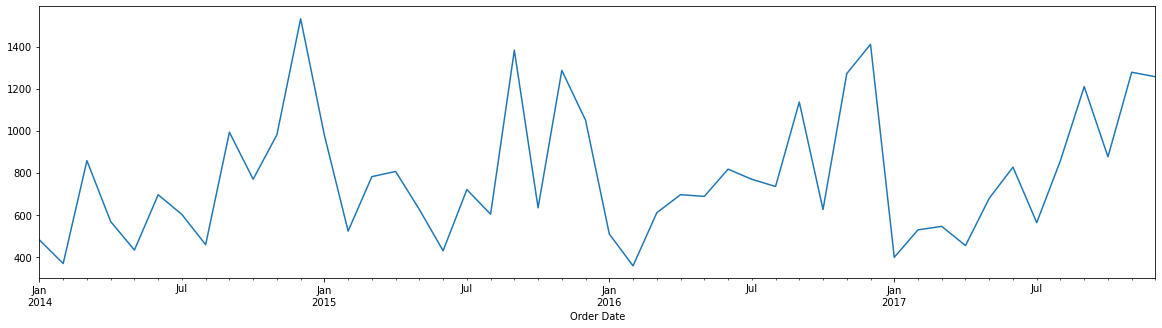

In [39]:
y_furniture.plot(figsize=(20,5))

<AxesSubplot:xlabel='Order Date'>

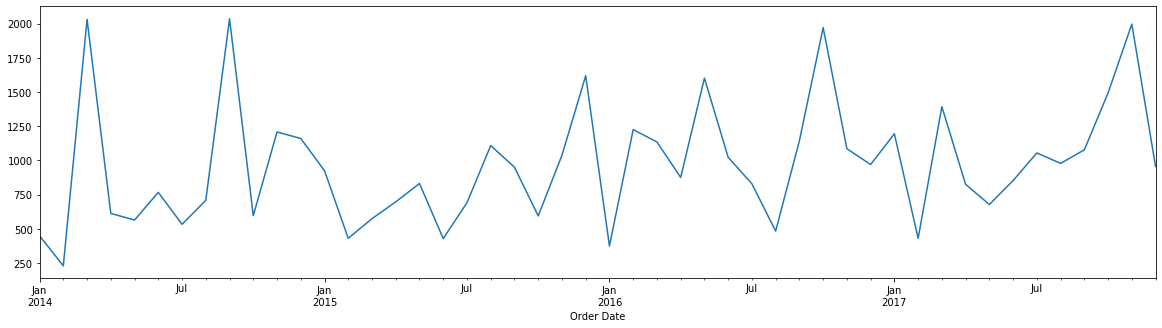

In [40]:
y_technology.plot(figsize=(20,5))

# Plotting the mean sales data for each categories

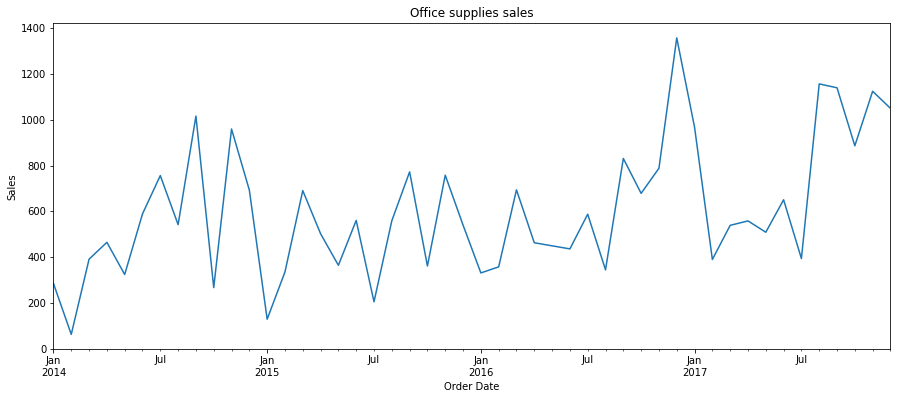

In [41]:
y_office.plot(figsize=(15,6))
plt.title("Office supplies sales")
plt.ylabel("Sales")
plt.show()

Text(0, 0.5, 'Sales')

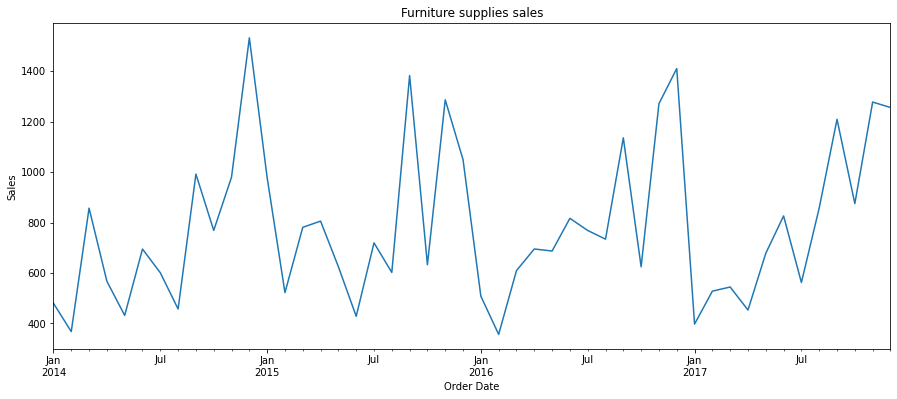

In [42]:
y_furniture.plot(figsize=(15,6))
plt.title("Furniture supplies sales")
plt.ylabel("Sales")

Text(0, 0.5, 'Sales')

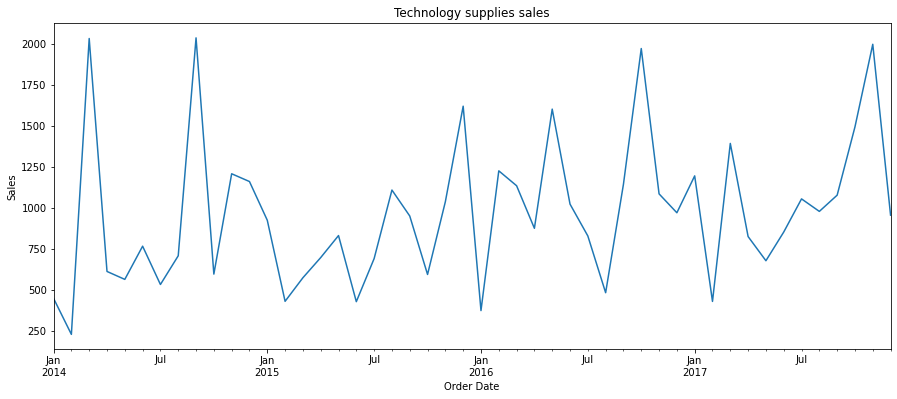

In [43]:
y_technology.plot(figsize=(15,6))
plt.title("Technology supplies sales")
plt.ylabel("Sales")

###### Boxplots on sales of each product categories

###### ETS decomposition of office

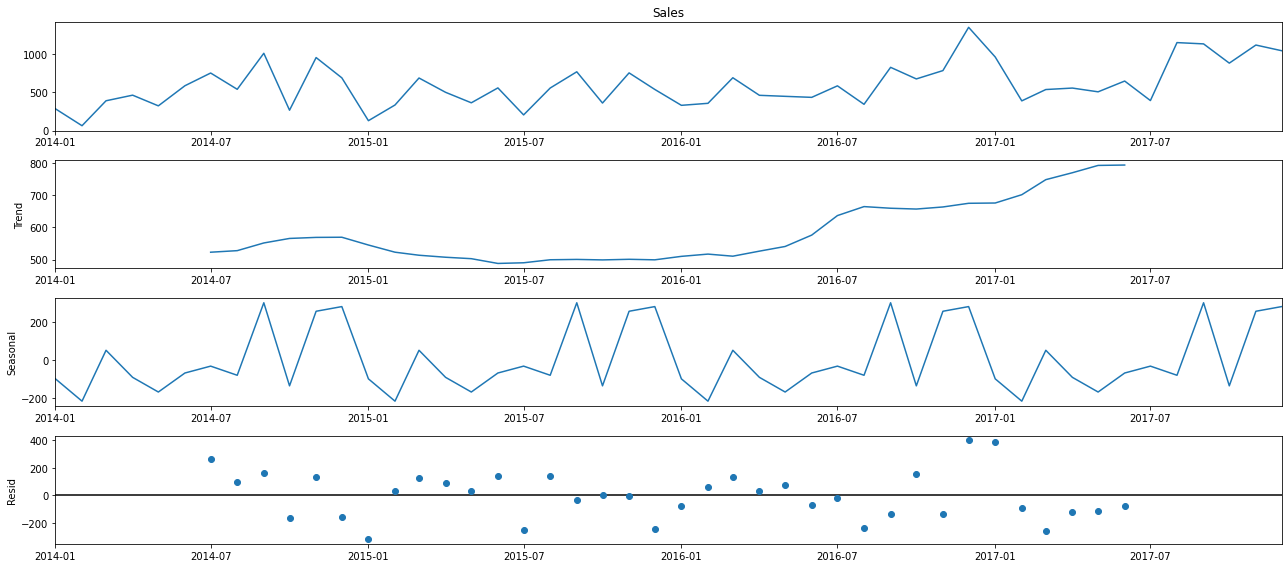

In [44]:

#ETS stands for Error-Trend-Seasonality and is a model used for the time series decomposition. 
#It decomposes the series into the error, trend and seasonality component. It is a univariate forecasting model used 
#when dealing with time-series data. It focuses on trend and seasonal components.
from pylab import rcParams
rcParams['figure.figsize']=18,8
decomposition_office = sm.tsa.seasonal_decompose(y_office,model='additive')
fig = decomposition_office.plot()
plt.show()

<AxesSubplot:xlabel='Order Date'>

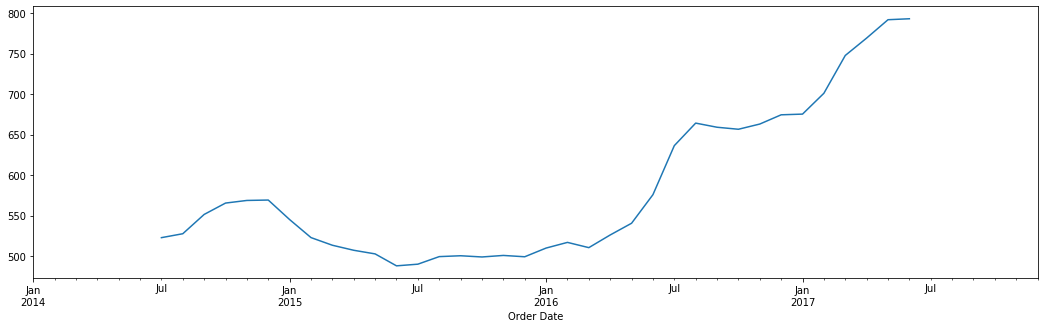

In [45]:
decomposition_office.trend.plot(figsize=(18,5))

<AxesSubplot:xlabel='Order Date'>

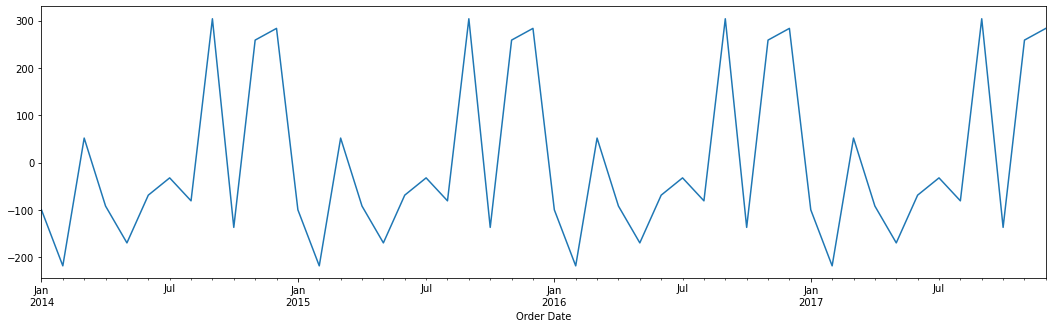

In [46]:
decomposition_office.seasonal.plot(figsize=(18,5))

In [47]:
###### ETS decomposition of furniture

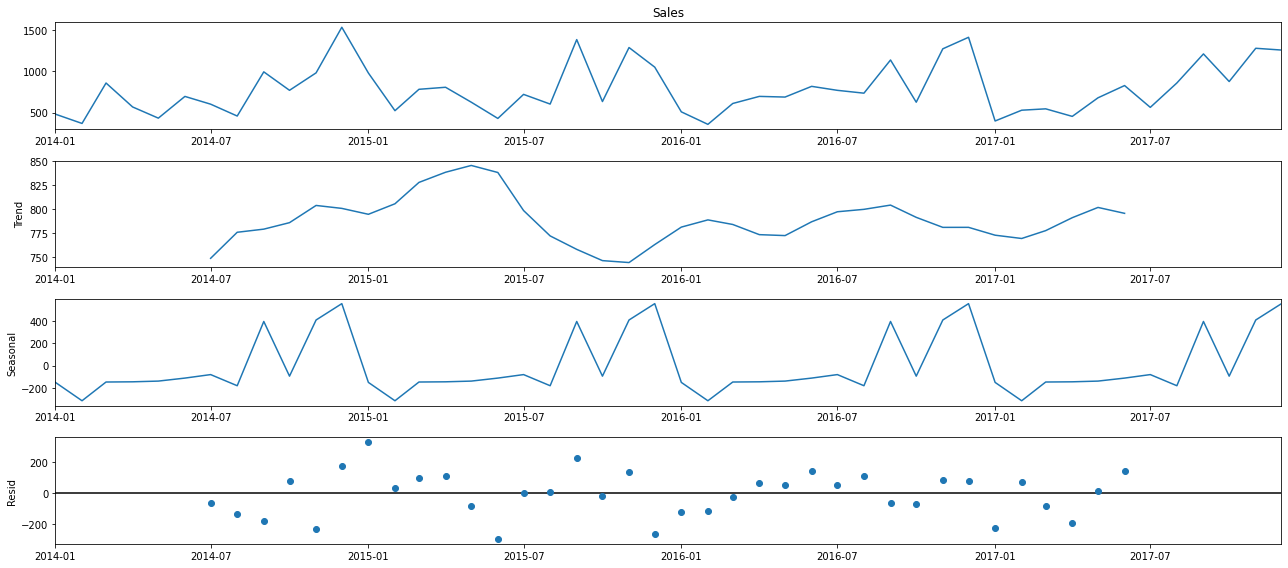

In [48]:
rcParams['figure.figsize']=18,8
decomposition_furniture = sm.tsa.seasonal_decompose(y_furniture,model='additive')
fig = decomposition_furniture.plot()
plt.show()

<AxesSubplot:xlabel='Order Date'>

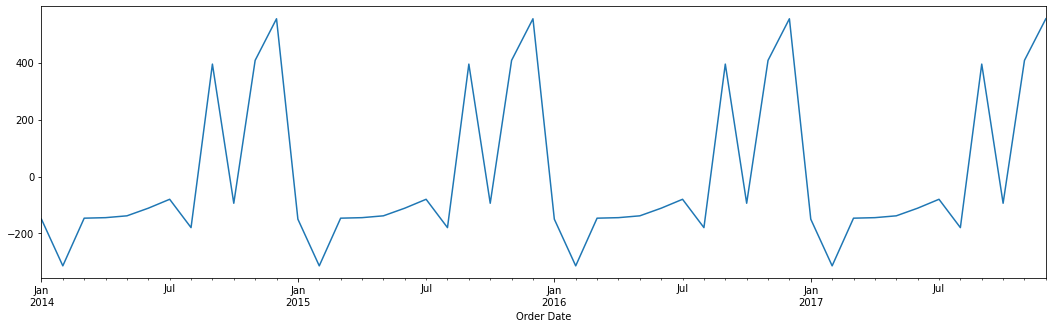

In [49]:
decomposition_furniture.seasonal.plot(figsize=(18,5))

<AxesSubplot:xlabel='Order Date'>

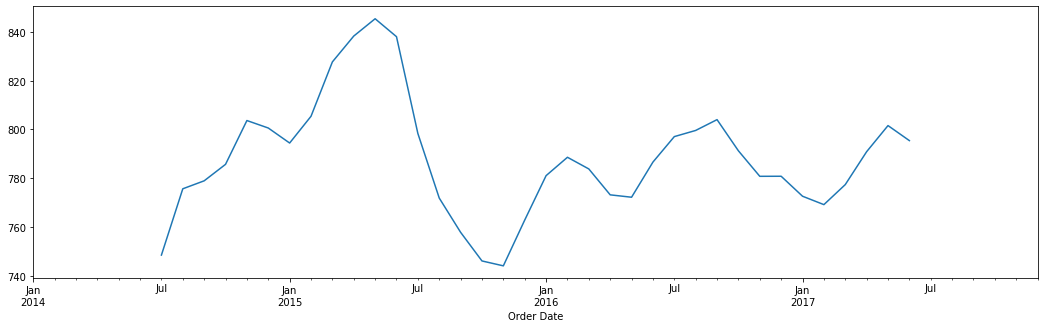

In [50]:
decomposition_furniture.trend.plot(figsize=(18,5))

In [51]:
###### ETS decomposition of technology

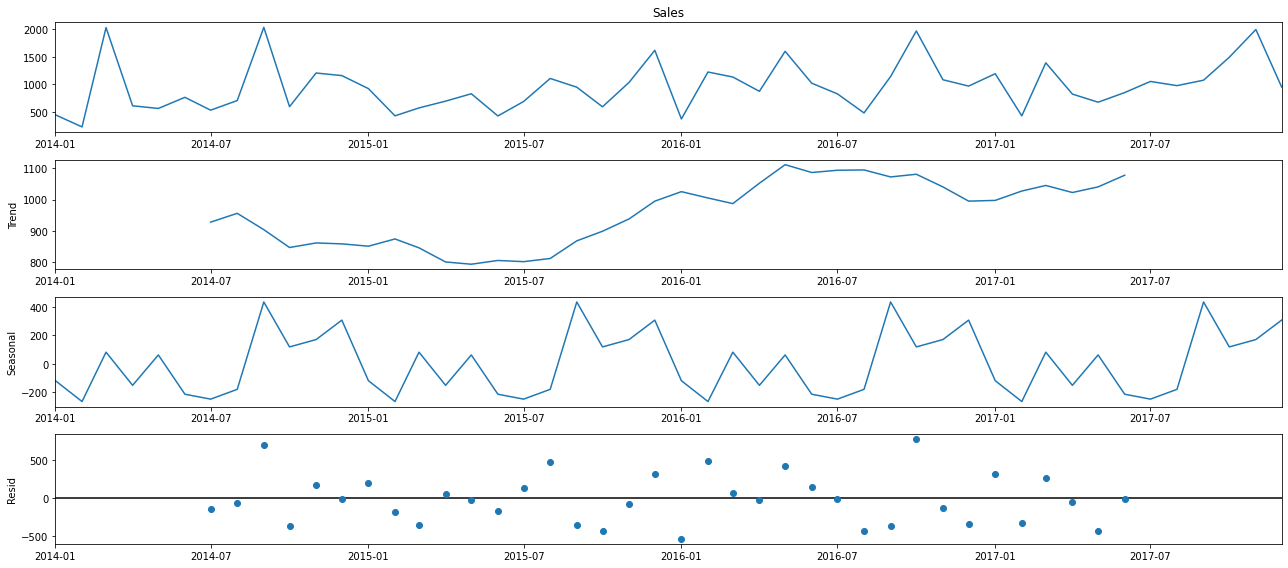

In [52]:
rcParams['figure.figsize']=18,8
decomposition_technology = sm.tsa.seasonal_decompose(y_technology,model='additive')
fig = decomposition_technology.plot()
plt.show()

<AxesSubplot:xlabel='Order Date'>

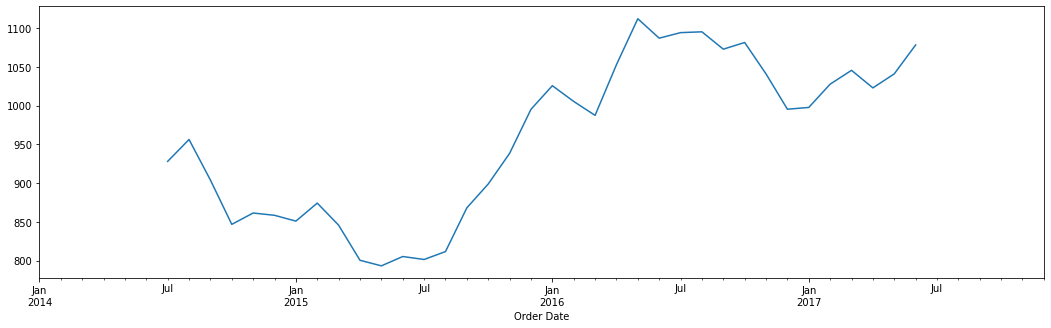

In [53]:
decomposition_technology.trend.plot(figsize=(18,5))

<AxesSubplot:xlabel='Order Date'>

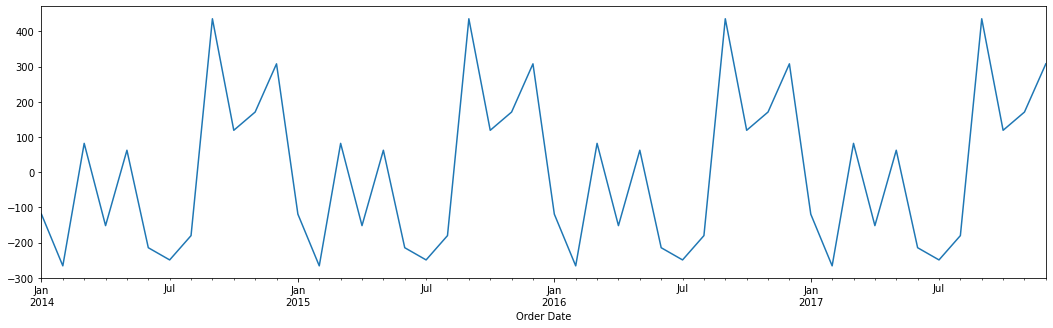

In [54]:
decomposition_technology.seasonal.plot(figsize=(18,5))

# Test for stationarity

In [55]:
rolmeanOffice=y_office.rolling(window=12).mean()
rolstdOffice=y_office.rolling(window=12).std()
print(rolmeanOffice,rolstdOffice)

Order Date
2014-01-01           NaN
2014-02-01           NaN
2014-03-01           NaN
2014-04-01           NaN
2014-05-01           NaN
2014-06-01           NaN
2014-07-01           NaN
2014-08-01           NaN
2014-09-01           NaN
2014-10-01           NaN
2014-11-01           NaN
2014-12-01    529.176439
2015-01-01    516.163182
2015-02-01    538.868316
2015-03-01    563.815749
2015-04-01    566.944713
2015-05-01    570.294955
2015-06-01    567.931065
2015-07-01    522.027260
2015-08-01    523.438554
2015-09-01    503.151302
2015-10-01    511.010741
2015-11-01    494.212211
2015-12-01    481.503842
2016-01-01    498.339805
2016-02-01    500.180903
2016-03-01    500.458546
2016-04-01    497.174393
2016-05-01    504.252750
2016-06-01    493.891472
2016-07-01    525.746471
2016-08-01    507.895697
2016-09-01    512.780456
2016-10-01    539.198456
2016-11-01    541.713612
2016-12-01    609.796956
2017-01-01    662.778874
2017-02-01    665.469321
2017-03-01    652.554508
2017-04-01    

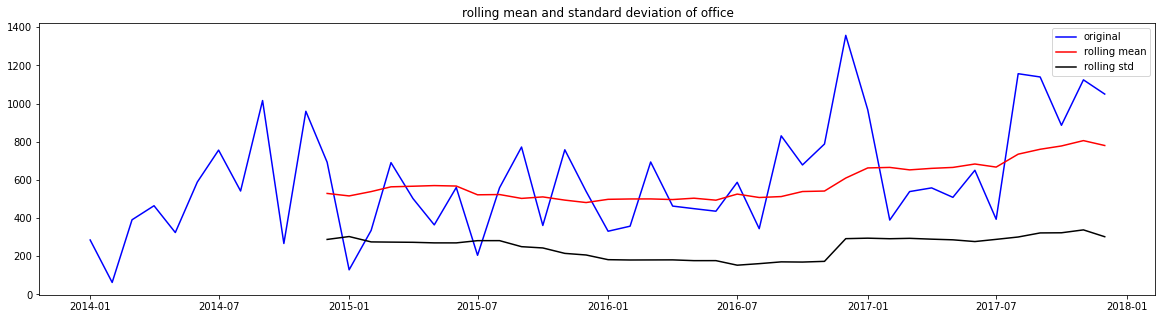

In [56]:
#Plotting the rolling statistics
plt.figure(figsize=(20,5))
orig=plt.plot(y_office,color='blue',label='original')
mean=plt.plot(rolmeanOffice,color='red',label='rolling mean')
std=plt.plot(rolstdOffice,color='black',label='rolling std')
plt.legend(loc='best')
plt.title('rolling mean and standard deviation of office')
plt.show(block=False)

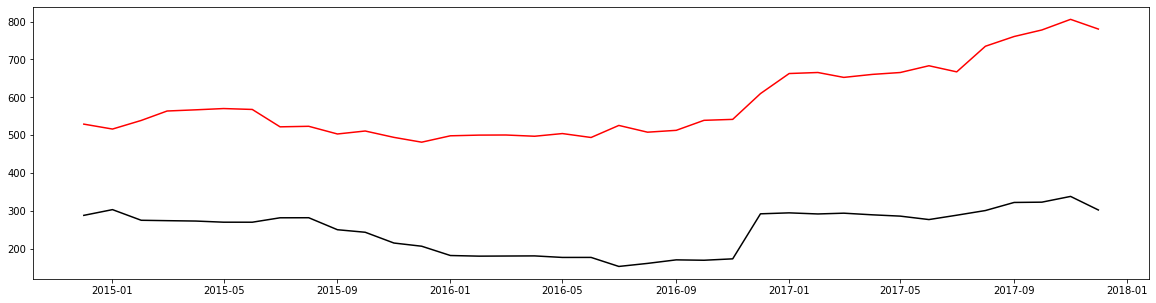

In [57]:
plt.figure(figsize=(20,5))
mean=plt.plot(rolmeanOffice,color='red',label='rolling mean')
std=plt.plot(rolstdOffice,color='black',label='rolling std')

In [58]:
rolmeanFurniture=y_furniture.rolling(window=12).mean()
rolstdFurniture=y_furniture.rolling(window=12).std()
print(rolmeanFurniture,rolstdFurniture)

Order Date
2014-01-01           NaN
2014-02-01           NaN
2014-03-01           NaN
2014-04-01           NaN
2014-05-01           NaN
2014-06-01           NaN
2014-07-01           NaN
2014-08-01           NaN
2014-09-01           NaN
2014-10-01           NaN
2014-11-01           NaN
2014-12-01    727.716160
2015-01-01    769.227346
2015-02-01    782.099352
2015-03-01    775.761427
2015-04-01    795.622644
2015-05-01    811.701604
2015-06-01    789.493792
2015-07-01    799.371860
2015-08-01    811.446056
2015-09-01    843.982499
2015-10-01    832.646228
2015-11-01    858.186217
2015-12-01    817.940975
2016-01-01    778.762175
2016-02-01    764.968226
2016-03-01    750.663173
2016-04-01    741.459023
2016-05-01    746.648067
2016-06-01    779.010171
2016-07-01    783.096012
2016-08-01    794.087327
2016-09-01    773.517550
2016-10-01    772.841908
2016-11-01    771.562224
2016-12-01    801.675924
2017-01-01    792.460862
2017-02-01    806.736823
2017-03-01    801.328192
2017-04-01    

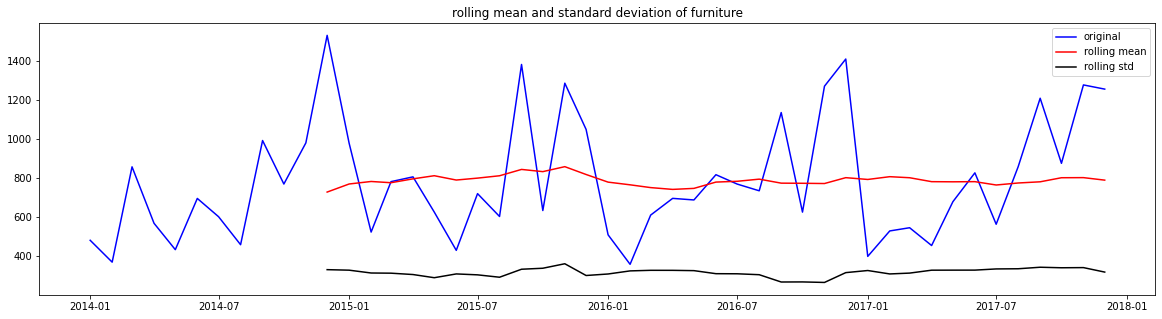

In [59]:
#Plotting the rolling statistics
plt.figure(figsize=(20,5))
orig=plt.plot(y_furniture,color='blue',label='original')
mean=plt.plot(rolmeanFurniture,color='red',label='rolling mean')
std=plt.plot(rolstdFurniture,color='black',label='rolling std')
plt.legend(loc='best')
plt.title('rolling mean and standard deviation of furniture')
plt.show(block=False)

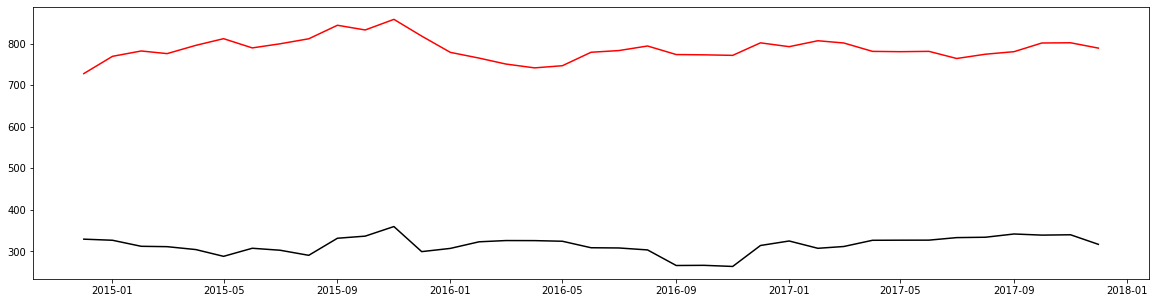

In [60]:
plt.figure(figsize=(20,5))
mean=plt.plot(rolmeanFurniture,color='red',label='rolling mean')
std=plt.plot(rolstdFurniture,color='black',label='rolling std')

In [61]:
rolmeanTechnology=y_technology.rolling(window=12).mean()
rolstdTechnology=y_technology.rolling(window=12).std()
print(rolmeanTechnology,rolstdTechnology)

Order Date
2014-01-01            NaN
2014-02-01            NaN
2014-03-01            NaN
2014-04-01            NaN
2014-05-01            NaN
2014-06-01            NaN
2014-07-01            NaN
2014-08-01            NaN
2014-09-01            NaN
2014-10-01            NaN
2014-11-01            NaN
2014-12-01     908.248578
2015-01-01     947.917692
2015-02-01     964.695535
2015-03-01     843.255031
2015-04-01     850.299245
2015-05-01     872.544601
2015-06-01     844.387808
2015-07-01     857.536875
2015-08-01     890.909117
2015-09-01     800.493972
2015-10-01     800.311907
2015-11-01     786.139101
2015-12-01     824.381163
2016-01-01     778.514519
2016-02-01     844.745365
2016-03-01     891.452679
2016-04-01     906.315378
2016-05-01     970.496487
2016-06-01    1020.016078
2016-07-01    1031.508976
2016-08-01     979.402127
2016-09-01     995.511618
2016-10-01    1110.188265
2016-11-01    1114.159908
2016-12-01    1060.069677
2017-01-01    1128.448594
2017-02-01    1062.166120
2

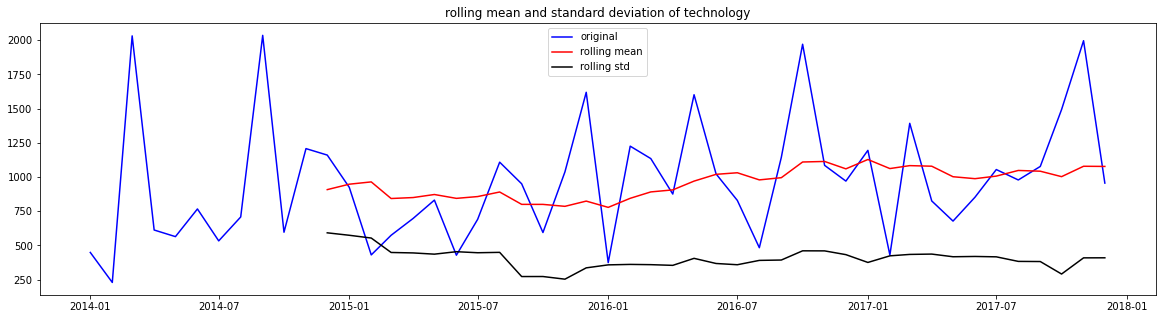

In [62]:
#Plotting the rolling statistics
plt.figure(figsize=(20,5))
orig=plt.plot(y_technology,color='blue',label='original')
mean=plt.plot(rolmeanTechnology,color='red',label='rolling mean')
std=plt.plot(rolstdTechnology,color='black',label='rolling std')
plt.legend(loc='best')
plt.title('rolling mean and standard deviation of technology')
plt.show(block=False)

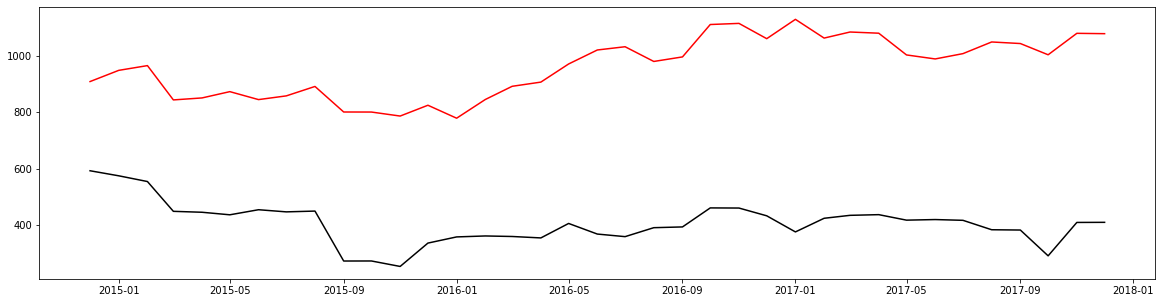

In [63]:
plt.figure(figsize=(20,5))
mean=plt.plot(rolmeanTechnology,color='red',label='rolling mean')
std=plt.plot(rolstdTechnology,color='black',label='rolling std')

In [64]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report 
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [65]:
adf_test(y_furniture)

Augmented Dickey-Fuller Test: 
ADF test statistic      -5.191070
p-value                  0.000009
# lags used             10.000000
# observations          37.000000
critical value (1%)     -3.620918
critical value (5%)     -2.943539
critical value (10%)    -2.610400
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [66]:
adf_test(y_office)

Augmented Dickey-Fuller Test: 
ADF test statistic      -4.664633
p-value                  0.000098
# lags used              0.000000
# observations          47.000000
critical value (1%)     -3.577848
critical value (5%)     -2.925338
critical value (10%)    -2.600774
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [67]:
adf_test(y_technology)

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.187969e+00
p-value                 2.547334e-10
# lags used             0.000000e+00
# observations          4.700000e+01
critical value (1%)    -3.577848e+00
critical value (5%)    -2.925338e+00
critical value (10%)   -2.600774e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


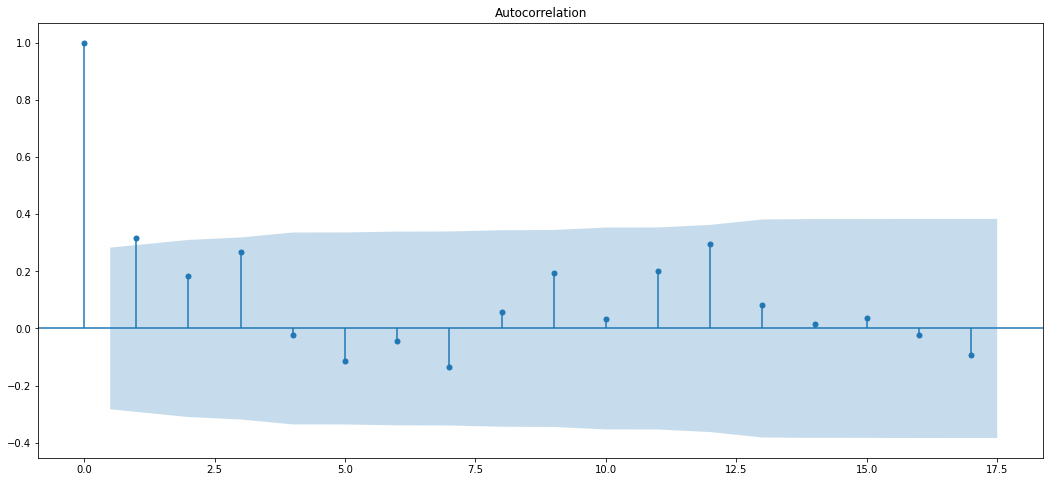

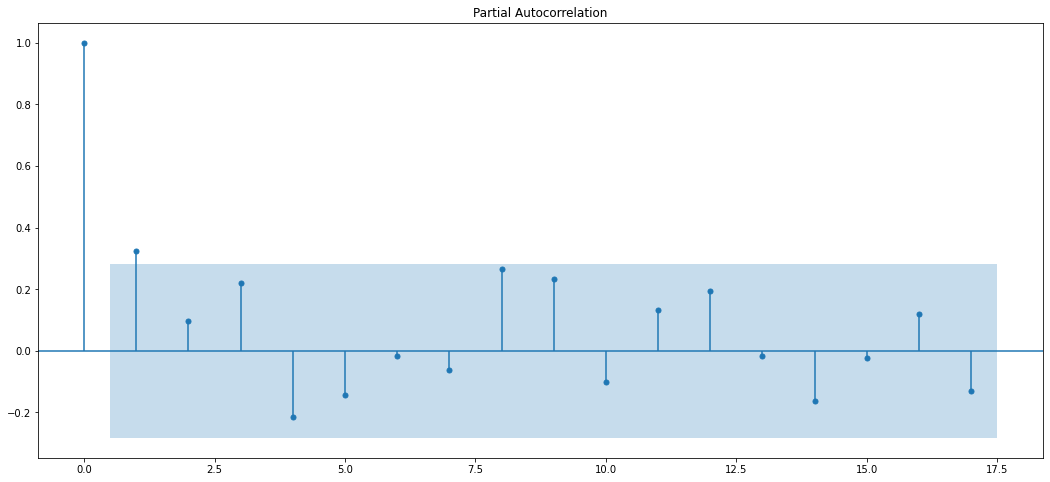

In [68]:
sm.graphics.tsa.plot_acf(y_office.values.squeeze())
sm.graphics.tsa.plot_pacf(y_office.values.squeeze())
plt.show()

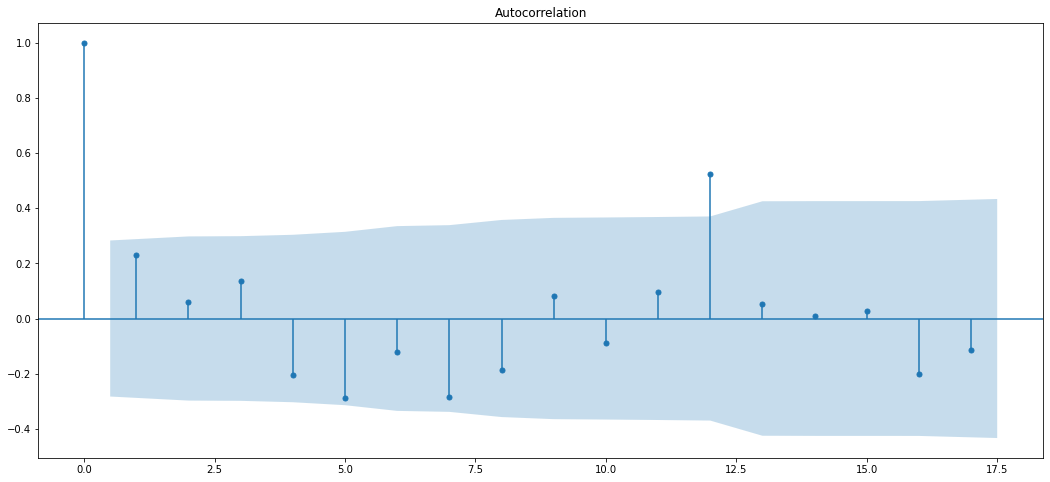

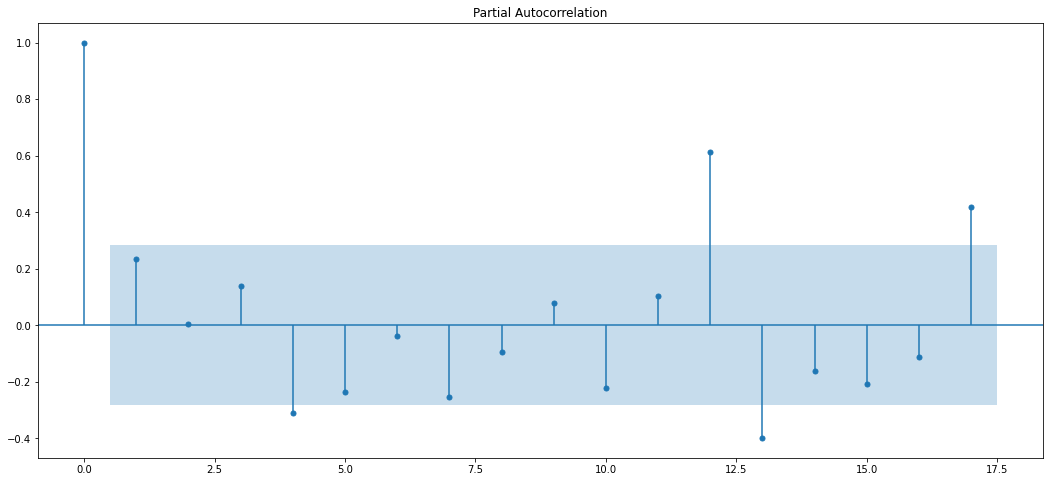

In [69]:
sm.graphics.tsa.plot_acf(y_furniture.values.squeeze())
sm.graphics.tsa.plot_pacf(y_furniture.values.squeeze())
plt.show()

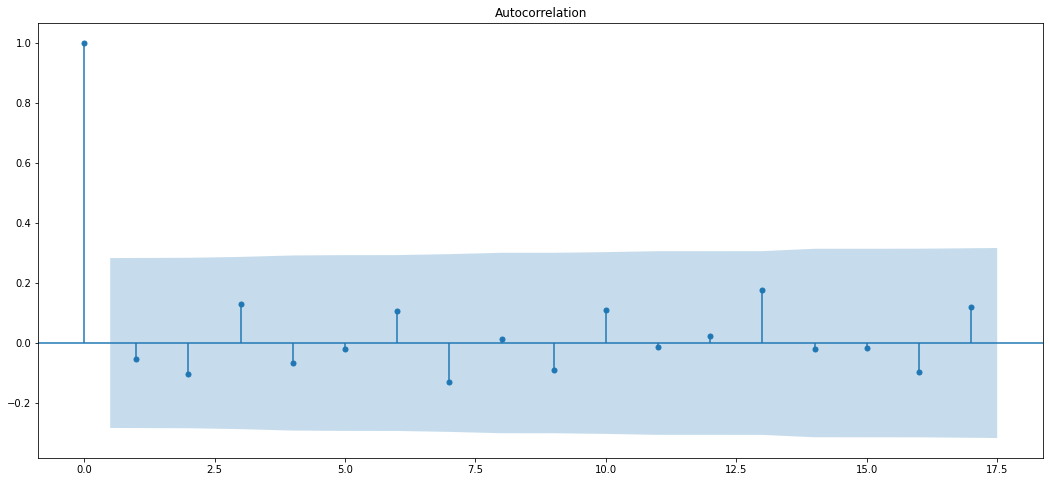

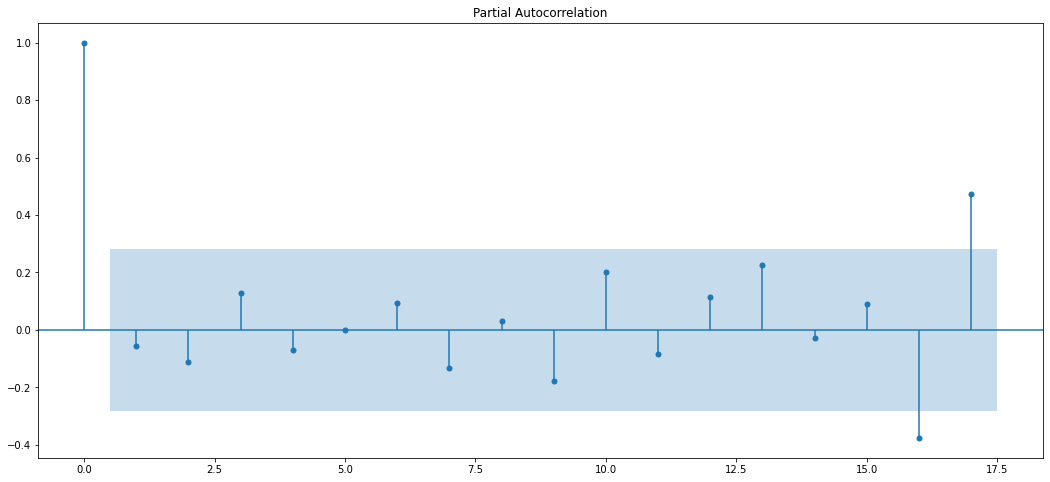

In [70]:
sm.graphics.tsa.plot_acf(y_technology.values.squeeze())
sm.graphics.tsa.plot_pacf(y_technology.values.squeeze())
plt.show()

# Time series forecasting with ARIMA

### find the order of arima

In [71]:
from pmdarima import auto_arima
warnings.filterwarnings("ignore")


In [72]:
#goal is to get minimum AIC value
stepwise_fit_office=  auto_arima(y_office,m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=667.410, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=682.234, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=672.340, Time=0.37 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=680.349, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=668.518, Time=0.65 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=5.41 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=6.31 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=668.754, Time=0.44 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=4.26 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=5.33 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=6.41 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.83 sec
 AR

In [73]:
stepwise_fit_office.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   48
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -325.705
Date:                              Thu, 21 Oct 2021   AIC                            667.410
Time:                                      13:49:34   BIC                            682.211
Sample:                                           0   HQIC                           672.979
                                               - 48                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4016     12.080      0.116      0.908     -22.275      25.078
ar.L1         -0.7929      0.428     -1.854      0.064      -1.631       0.045
ar.L2          0.1762      0.492      0.358      0.720      -0.789       1.141
ma.L1         -0.0031      0.608     -0.005      0.996      -1.195       1.189
ma.L2         -0.9734      0.832     -1.170      0.242      -2.604       0.657
ar.S.L12       0.8965      0.857      1.047      0.295      -0.782       2.575
ma.S.L12      -0.6833      1.458     -0.469      0.639      -3.540       2.173
sigma2      6.871e+04   4.15e+04      1.657      0.098   -1.26e+04     1.5e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 2.97
Prob(Q):                              0.79   Prob(JB):                         0.23
Heteroskedasticity (H):               1.11   Skew:                             0.60
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA for Office sales

In [74]:
train= y_office.iloc[:36]
test= y_office.iloc[36:]

In [75]:
model_office = SARIMAX(train,order=(0, 1, 1),seasonal_order=(2, 0, 0, 12),enforce_invertibility=False)

In [76]:
final_office = model_office.fit()

In [77]:
final_office.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                   36
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 12)   Log Likelihood                -242.536
Date:                             Thu, 21 Oct 2021   AIC                            493.072
Time:                                     13:49:35   BIC                            499.294
Sample:                                 01-01-2014   HQIC                           495.220
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9292      0.151     -6.143      0.000      -1.226      -0.633
ar.S.L12       0.3049      0.315      0.969      0.333      -0.312       0.922
ar.S.L24       0.3410      0.504      0.677      0.499      -0.647       1.329
sigma2      4.942e+04    1.6e+04      3.094      0.002    1.81e+04    8.07e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 7.89
Prob(Q):                              0.68   Prob(JB):                         0.02
Heteroskedasticity (H):               0.98   Skew:                             0.74
Prob(H) (two-sided):                  0.98   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
start = len(train)
end = len(train) + len(test) - 1

In [79]:
prediction_office = final_office.predict(start,end).rename('SARIMA model predictions')
prediction_office

2017-01-01    408.624508
2017-02-01    487.009639
2017-03-01    710.608492
2017-04-01    576.016158
2017-05-01    524.933148
2017-06-01    587.624901
2017-07-01    512.678186
2017-08-01    559.191619
2017-09-01    780.226163
2017-10-01    593.658256
2017-11-01    762.228765
2017-12-01    861.511292
Freq: MS, Name: SARIMA model predictions, dtype: float64

Text(0.5, 1.0, 'Office supplies sales')

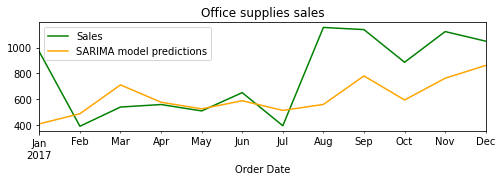

In [80]:
test.plot(figsize=(8,2),legend=True,color= 'green')
prediction_office.plot(legend=True,color= 'orange')
plt.title("Office supplies sales")

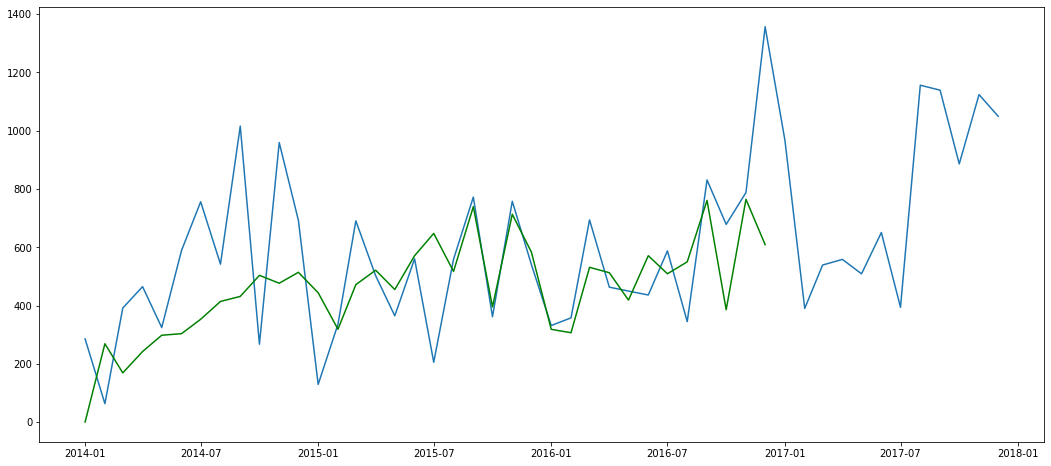

In [81]:
#Model Fitting

plt.plot(y_office)
plt.plot(final_office.fittedvalues, color='green')
plt.show()

In [82]:
mean_squared_error(test,prediction_office)

92188.293387504

In [83]:
rmse(test,prediction_office)

303.6252515643322

In [84]:
test.mean()

780.1716465938612

In [85]:
train_office = y_office.iloc[:36]
test_office = y_office.iloc[36:]

In [86]:
###### Now let us forecast into the unknown future


In [87]:
model_office_final = SARIMAX(y_office,order=(0, 1, 1),seasonal_order=(2, 0, 0, 12),enforce_invertibility=False)

In [88]:
result_office_final = model_office_final.fit()

In [89]:
forecast_office = result_office_final.predict(len(y_office),len(y_office)+11,typ='levels').rename('SARIMA forecast')

Text(0.5, 1.0, 'Office supplies sales')

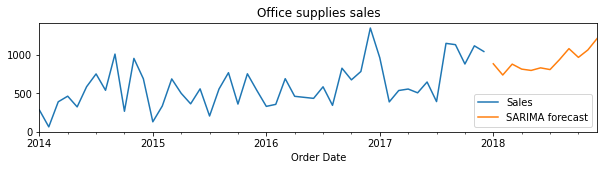

In [90]:
y_office.plot(legend=True,figsize=(10,2))
forecast_office.plot(legend=True)
plt.title("Office supplies sales")

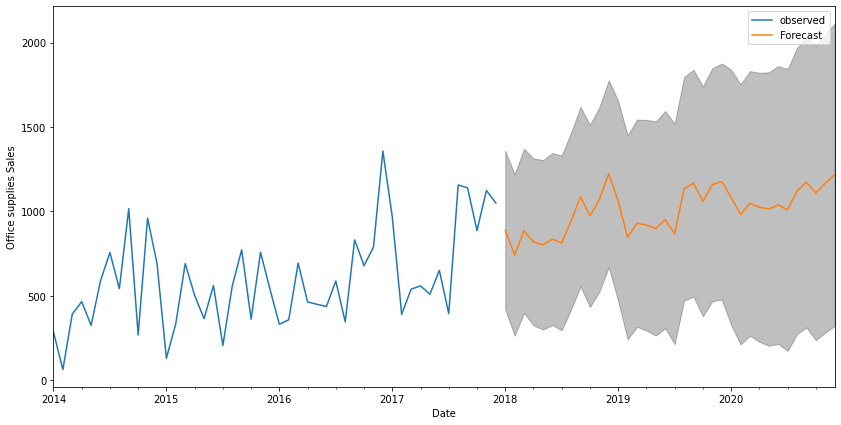

In [91]:
pred_office = result_office_final.get_forecast(steps=36)
pred_ci_office = pred_office.conf_int()
ax = y_office.plot(label='observed',figsize=(14,7))
pred_office.predicted_mean.plot(ax=ax,label='Forecast')
ax.fill_between(pred_ci_office.index,
               pred_ci_office.iloc[:,0],
               pred_ci_office.iloc[:,1],color='k',alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Office supplies Sales')
plt.legend()
plt.show()

In [92]:
stepwise_fit_furniture= auto_arima(y_furniture,m=12,seasonal=True,trace=True,supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=494.533, Time=1.24 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=497.083, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=494.685, Time=0.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=495.371, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=496.066, Time=1.02 sec
 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=501.842, Time=6.43 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=500.154, Time=7.06 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=494.998, Time=5.90 sec
 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=inf, Time=5.37 sec
 ARIMA(2,0,2)(2,1,2)[12] intercept   : AIC=503.547, Time=7.09 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=498.528, Time=1.12 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, T

In [93]:
stepwise_fit_furniture.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   48
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 12)   Log Likelihood                -239.267
Date:                              Thu, 21 Oct 2021   AIC                            494.533
Time:                                      13:50:24   BIC                            507.202
Sample:                                           0   HQIC                           498.955
                                               - 48                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1942      1.682     -0.116      0.908      -3.490       3.101
ar.L1          1.7062      0.206      8.300      0.000       1.303       2.109
ar.L2         -0.8538      0.181     -4.728      0.000      -1.208      -0.500
ma.L1         -1.9403      2.014     -0.964      0.335      -5.887       2.006
ma.L2          0.9510      1.882      0.505      0.613      -2.738       4.640
ar.S.L12      -0.1222      0.562     -0.217      0.828      -1.224       0.980
ma.S.L12      -0.8581      3.172     -0.270      0.787      -7.076       5.360
sigma2      1.906e+04   7.09e+04      0.269      0.788    -1.2e+05    1.58e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.94   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.33   Prob(JB):                         0.80
Heteroskedasticity (H):               0.45   Skew:                             0.04
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
train= y_furniture.iloc[:36]
test= y_furniture.iloc[36:]

In [95]:
model_furniture = SARIMAX(train,order=(2, 0, 2),seasonal_order=(1, 1, 1, 12),enforce_invertibility=False)

In [96]:
final_furniture = model_furniture.fit()

In [97]:
final_furniture.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                   36
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 12)   Log Likelihood                -161.164
Date:                              Thu, 21 Oct 2021   AIC                            336.327
Time:                                      13:50:25   BIC                            344.573
Sample:                                  01-01-2014   HQIC                           338.515
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2167      0.903     -1.348      0.178      -2.986       0.553
ar.L2         -0.7914      0.854     -0.927      0.354      -2.465       0.882
ma.L1          1.4036      0.768      1.829      0.067      -0.101       2.908
ma.L2          0.9819      0.959      1.024      0.306      -0.897       2.861
ar.S.L12      -0.7495      1.529     -0.490      0.624      -3.746       2.247
ma.S.L12      -0.0241      3.328     -0.007      0.994      -6.547       6.498
sigma2      2.681e+04   2.13e+04      1.260      0.208   -1.49e+04    6.85e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):                 0.61
Prob(Q):                              0.38   Prob(JB):                         0.74
Heteroskedasticity (H):               0.70   Skew:                            -0.31
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
start = len(train)
end = len(train) + len(test) - 1

In [99]:
prediction_furniture = final_furniture.predict(start,end).rename('SARIMA model predictions')
prediction_furniture

2017-01-01     820.330888
2017-02-01     517.352956
2017-03-01     734.411136
2017-04-01     759.893780
2017-05-01     663.080234
2017-06-01     500.959514
2017-07-01     731.661626
2017-08-01     642.066019
2017-09-01    1302.173427
2017-10-01     645.139177
2017-11-01    1277.487285
2017-12-01    1131.008987
Freq: MS, Name: SARIMA model predictions, dtype: float64

Text(0.5, 1.0, 'Furniture sales')

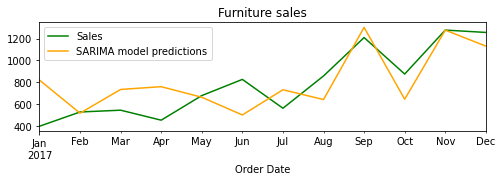

In [100]:
test.plot(figsize=(8,2),legend=True,color= 'green')
prediction_furniture.plot(legend=True,color= 'orange')
plt.title("Furniture sales")

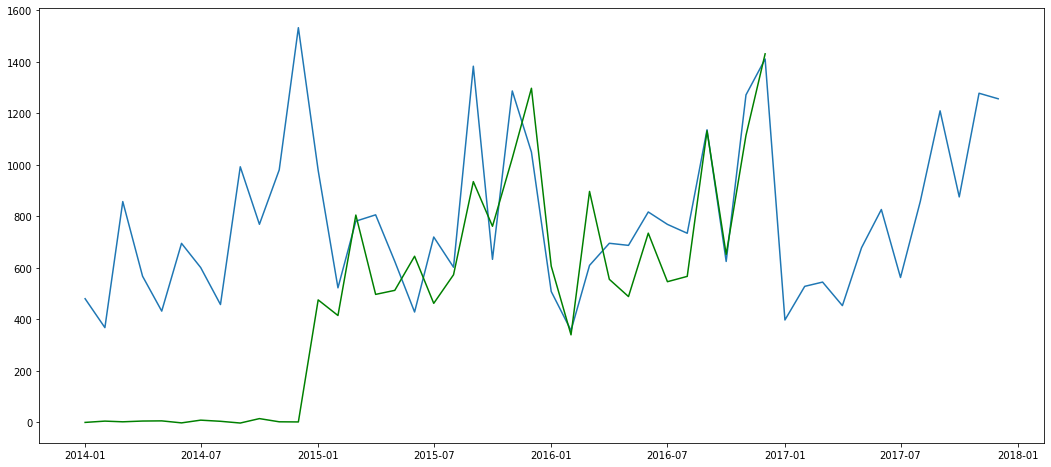

In [101]:
#Model Fitting

plt.plot(y_furniture)
plt.plot(final_furniture.fittedvalues, color='green')
plt.show()

In [102]:
mean_squared_error(test,prediction_furniture)

47289.347875161904

In [103]:
rmse(test,prediction_furniture)

217.4611410692998

In [104]:
test.mean()

788.9924321352877

In [105]:
train_furniture = y_furniture.iloc[:36]
test_furniture = y_furniture.iloc[36:]

In [106]:
###### Now let us forecast into the unknown future


In [107]:
model_furniture_final = SARIMAX(y_furniture,order=(0, 1, 1),seasonal_order=(2, 0, 0, 12),enforce_invertibility=False)

In [108]:
result_furniture_final = model_furniture_final.fit()

In [109]:
forecast_furniture = result_furniture_final.predict(len(y_furniture),len(y_furniture)+11,typ='levels').rename('SARIMA forecast')

Text(0.5, 1.0, 'Furniture sales')

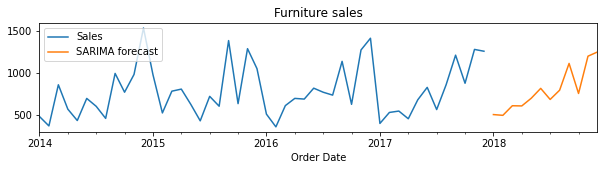

In [110]:
y_furniture.plot(legend=True,figsize=(10,2))
forecast_furniture.plot(legend=True)
plt.title("Furniture sales")

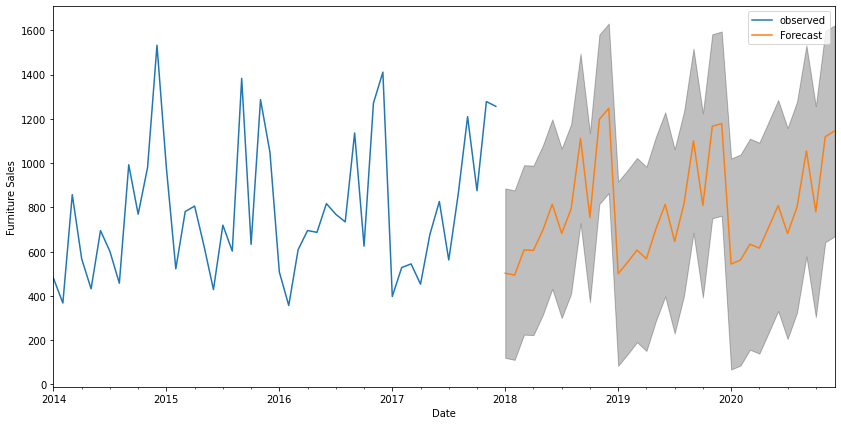

In [111]:
pred_furniture = result_furniture_final.get_forecast(steps=36)
pred_ci_furniture = pred_furniture.conf_int()
ax = y_furniture.plot(label='observed',figsize=(14,7))
pred_furniture.predicted_mean.plot(ax=ax,label='Forecast')
ax.fill_between(pred_ci_furniture.index,
               pred_ci_furniture.iloc[:,0],
               pred_ci_furniture.iloc[:,1],color='k',alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [112]:
## technology

In [113]:
stepwise_fit_technology= auto_arima(y_technology,m=12,seasonal=True,trace=True,supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=725.877, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=729.717, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=729.615, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=807.454, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=727.873, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=727.843, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=729.843, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=727.740, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=727.697, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=729.641, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.869 seconds


In [114]:
stepwise_fit_technology.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:                        SARIMAX   Log Likelihood                -360.939
Date:                Thu, 21 Oct 2021   AIC                            725.877
Time:                        13:50:29   BIC                            729.620
Sample:                             0   HQIC                           727.291
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    967.6149     77.667     12.458      0.000     815.390    1119.840
sigma2       1.99e+05   4.64e+04      4.292      0.000    1.08e+05     2.9e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 5.70
Prob(Q):                              0.70   Prob(JB):                         0.06
Heteroskedasticity (H):               0.69   Skew:                             0.84
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [115]:
train= y_technology.iloc[:36]
test= y_technology.iloc[36:]

In [116]:
model_technology = SARIMAX(train,order=(0, 0, 0),seasonal_order=(0, 0, 0, 12),enforce_invertibility=False)

In [117]:
final_technology = model_technology.fit()

In [118]:
final_technology.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   36
Model:                        SARIMAX   Log Likelihood                -301.066
Date:                Thu, 21 Oct 2021   AIC                            604.133
Time:                        13:50:30   BIC                            605.716
Sample:                    01-01-2014   HQIC                           604.686
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.075e+06   3.58e+05      3.007      0.003    3.74e+05    1.78e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 5.55
Prob(Q):                              0.51   Prob(JB):                         0.06
Heteroskedasticity (H):               1.13   Skew:                             0.95
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [119]:
start = len(train)
end = len(train) + len(test) - 1

In [120]:
prediction_technology = final_technology.predict(start,end).rename('SARIMA model predictions')
prediction_technology

2017-01-01    0.0
2017-02-01    0.0
2017-03-01    0.0
2017-04-01    0.0
2017-05-01    0.0
2017-06-01    0.0
2017-07-01    0.0
2017-08-01    0.0
2017-09-01    0.0
2017-10-01    0.0
2017-11-01    0.0
2017-12-01    0.0
Freq: MS, Name: SARIMA model predictions, dtype: float64

Text(0.5, 1.0, 'Technology sales')

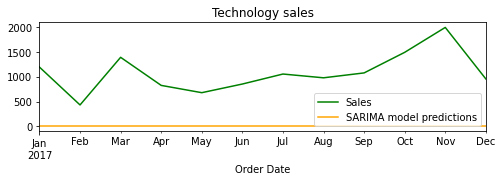

In [121]:
test.plot(figsize=(8,2),legend=True,color= 'green')
prediction_technology.plot(legend=True,color= 'orange')
plt.title("Technology sales")

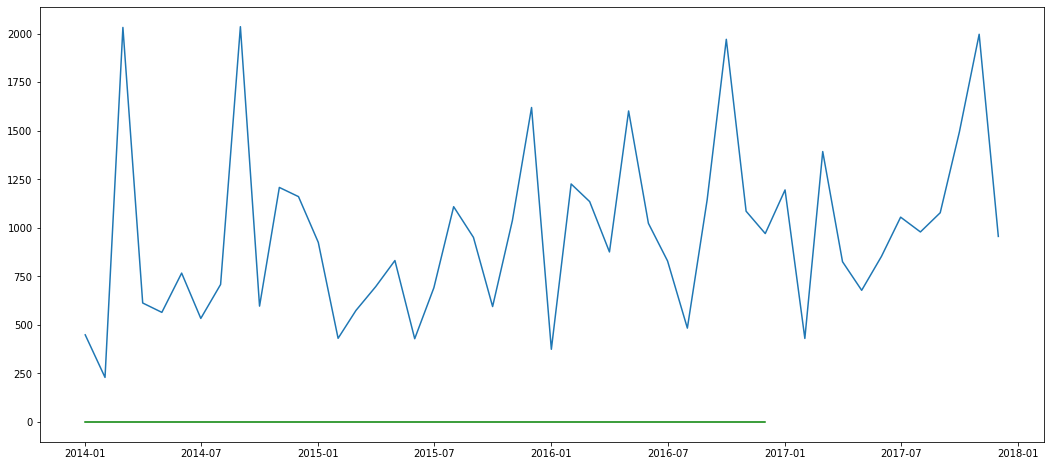

In [122]:
#Model Fitting

plt.plot(y_technology)
plt.plot(final_technology.fittedvalues, color='green')
plt.show()

In [123]:
mean_squared_error(test,prediction_technology)

1315580.5698962545

In [124]:
rmse(test,prediction_technology)

1146.9876066881693

In [125]:
test.mean()

1077.7601215159357

In [126]:
train_technology = y_technology.iloc[:36]
test_technology = y_technology.iloc[36:]

In [127]:
###### Now let us forecast into the unknown future


In [128]:
model_technology_final = SARIMAX(y_technology,order=(0, 1, 1),seasonal_order=(2, 0, 0, 12),enforce_invertibility=False)

In [129]:
result_technology_final = model_technology_final.fit()

In [130]:
forecast_technology = result_technology_final.predict(len(y_technology),len(y_technology)+11,typ='levels').rename('SARIMA forecast')

Text(0.5, 1.0, 'Office supplies sales')

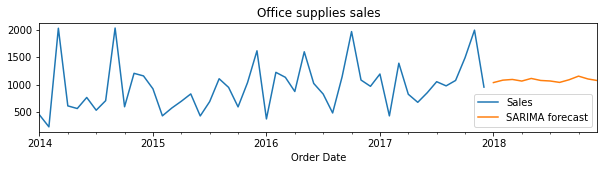

In [131]:
y_technology.plot(legend=True,figsize=(10,2))
forecast_technology.plot(legend=True)
plt.title("Office supplies sales")

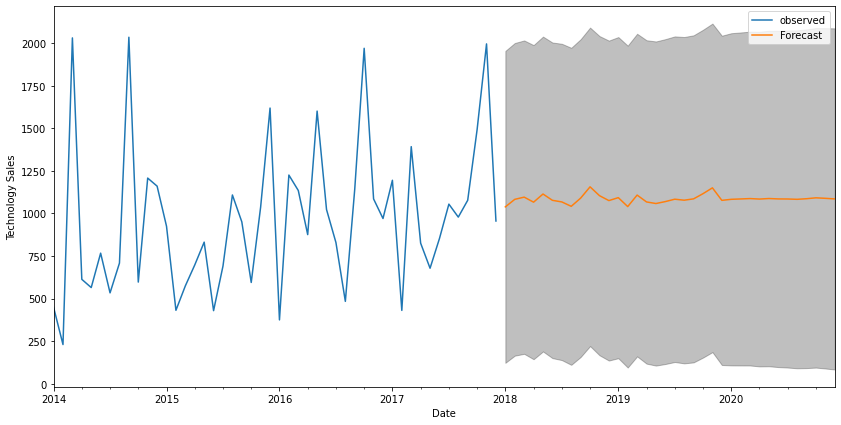

In [132]:
pred_technology = result_technology_final.get_forecast(steps=36)
pred_ci_technology = pred_technology.conf_int()
ax = y_technology.plot(label='observed',figsize=(14,7))
pred_technology.predicted_mean.plot(ax=ax,label='Forecast')
ax.fill_between(pred_ci_technology.index,
               pred_ci_technology.iloc[:,0],
               pred_ci_technology.iloc[:,1],color='k',alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Technology Sales')
plt.legend()
plt.show()